In [1]:
!pip install missingno -q
!pip install phik -q
!pip install scikit-learn --upgrade -q
!pip install shap -q
!pip install phik -q


In [2]:
#pip install phik

In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from scipy import stats
import seaborn as sns
from typing import List
from scipy.stats import shapiro
import shap
import warnings
from sklearn.datasets import make_classification
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pandas as pdfrom 
from sklearn.compose import ColumnTransformer

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

**Шаг 1. Загрузка данных**

In [5]:
df_market_file = pd.read_csv('/datasets/market_file.csv')
df_market_money = pd.read_csv('/datasets/market_money.csv')
df_market_time = pd.read_csv('/datasets/market_time.csv', decimal=',')
df_money = pd.read_csv('/datasets/money.csv', sep = ';', decimal=',')

In [6]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [9]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Шаг 2. Предобработка данных**

Подсчет дубликатов в каждом файле

In [10]:
#list из файлов
all_frames = [df_market_file, df_market_money, df_market_time, df_money]

for data in all_frames:
    names = [key for key, value in locals().items() if value is data][0]
    print(f'Количество дубликатов в {names}: {data.duplicated().sum()}')

Количество дубликатов в df_market_file: 0
Количество дубликатов в df_market_money: 0
Количество дубликатов в df_market_time: 0
Количество дубликатов в df_money: 0


Анализ уникальных значений в таблице, которая содержит данные о поведении покупателя на сайте

In [11]:
columns = ['Покупательская активность', 'Тип сервиса', 'Популярная_категория']

def function_for_duplicates(columns, data_frame):
    for i in columns:
        unique_values = data_frame[i].unique()
        print(f'Уникальные значения для колонки - {i}: {unique_values}', end='\n')
        

function_for_duplicates(columns, df_market_file)

Уникальные значения для колонки - Покупательская активность: ['Снизилась' 'Прежний уровень']
Уникальные значения для колонки - Тип сервиса: ['премиум' 'стандартт' 'стандарт']
Уникальные значения для колонки - Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [12]:
columns = ['Период']
function_for_duplicates(columns, df_market_money)

Уникальные значения для колонки - Период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [13]:
columns = ['Период']
function_for_duplicates(columns, df_market_time)

Уникальные значения для колонки - Период: ['текущий_месяц' 'предыдцщий_месяц']


Выявляем неявные дубликаты

In [14]:
df_market_file['Тип сервиса'] = df_market_file['Тип сервиса'].replace('стандартт','стандарт')

In [15]:
df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц','предыдущий_месяц')

In [16]:
for i in all_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'прошущенные значения в {data_name}:\n{i.isnull().sum().sort_values()}')
    print()

прошущенные значения в df_money:
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

прошущенные значения в df_money:
id         0
Период     0
Выручка    0
dtype: int64

прошущенные значения в df_money:
id        0
Период    0
минут     0
dtype: int64

прошущенные значения в df_money:
id         0
Прибыль    0
dtype: int64



Выбор строк с ненулевой выручкой

In [17]:
df_market_money_filltred = df_market_money.loc[(df_market_money['Выручка'] > 0).groupby(df_market_money['id']).transform('all')]

In [18]:
df_market_money_filltred.head()

,id,Период,Выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


In [19]:
df_market_file_filtered = df_market_file[df_market_file['id'].isin(df_market_money_filltred['id'])]

In [20]:
df_market_time_filtered = df_market_time[df_market_time['id'].isin(df_market_money_filltred['id'])]

In [21]:
df_money_filtered = df_money[df_money['id'].isin(df_market_money_filltred['id'])]

Промежуточный вывод:
В колонке 'тип сервиса' неявный дубликат
В колонке 'Период' ошибка
Пропусков нет

**Шаг 3. Исследовательский анализ данных**

In [22]:
def function_for_histogram(data, column, bins=50):
    plt.figure(figsize=(12, 6))
    sns.set()
    sns.histplot(data=data, x=column, kde=True, bins=bins)
    plt.title(f'{column} - Плотность распределения', fontsize=20)
    plt.xlabel(column, fontsize=15)
    plt.ylabel('Частота', fontsize=15)
    plt.show()

In [23]:
#Создание списков с количественными и категориальными данными

def cat_num_col(df):
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    num_col_names.remove('id')
    return num_col_names, cat_col_names

In [24]:
num_col_names_market, cat_col_names_market = cat_num_col(df_market_file_filtered)

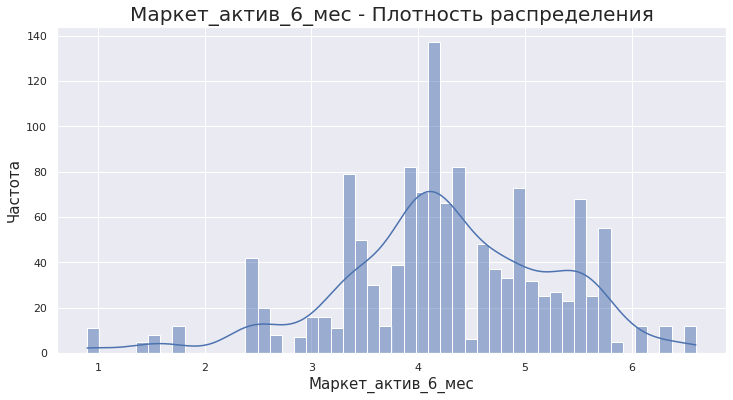

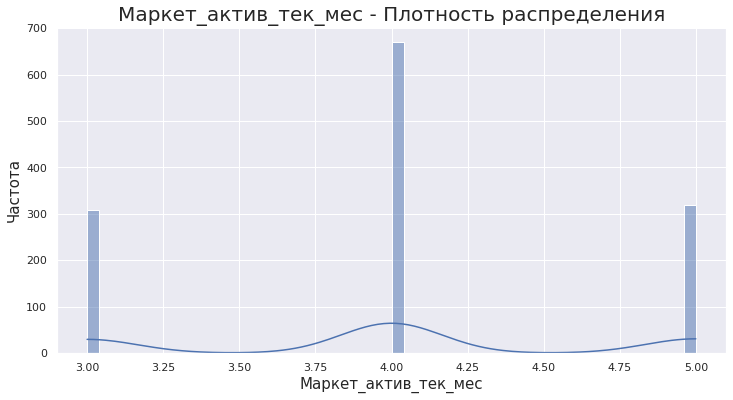

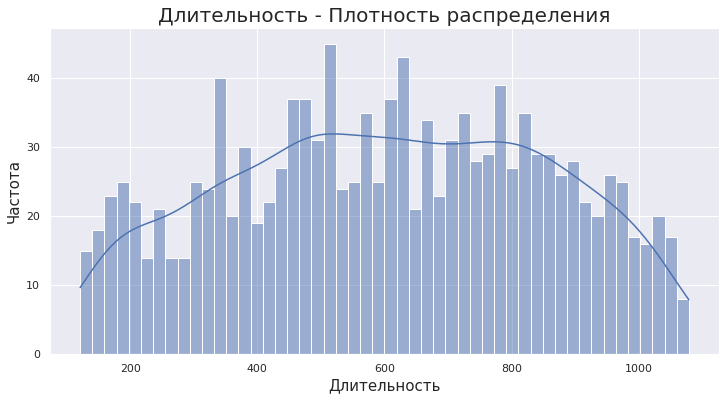

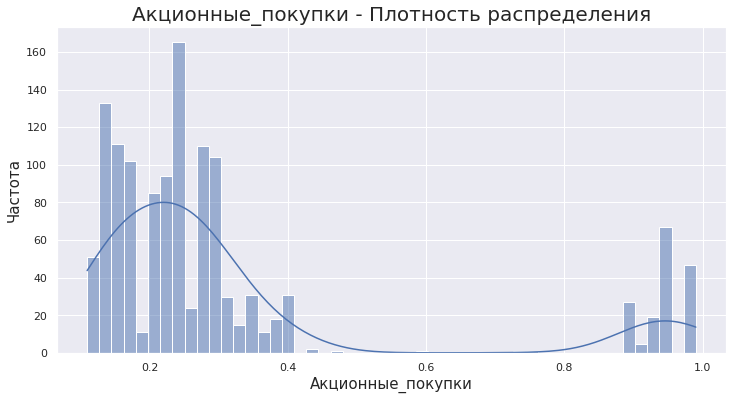

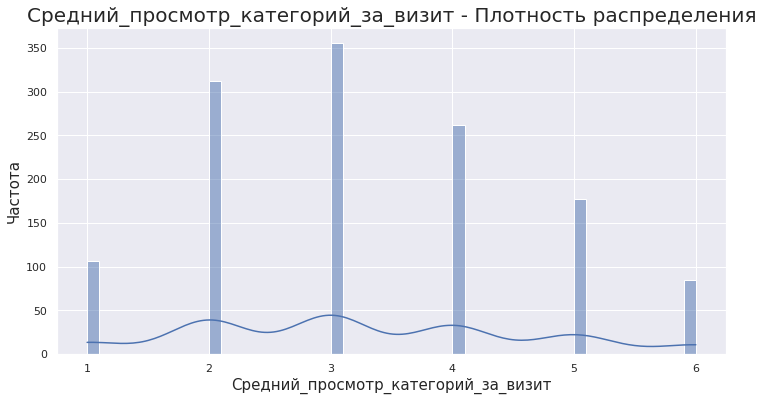

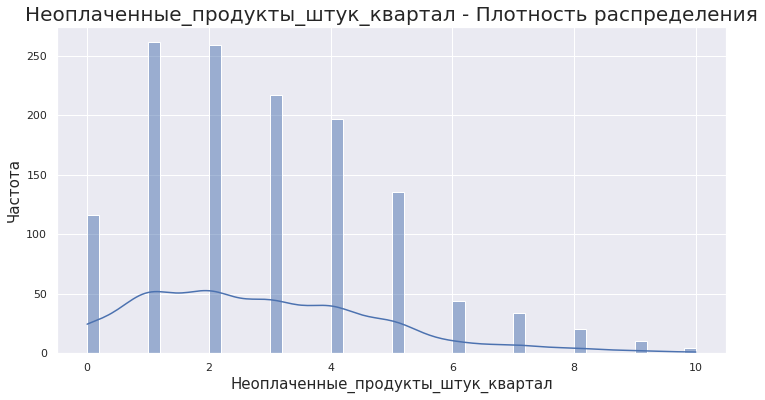

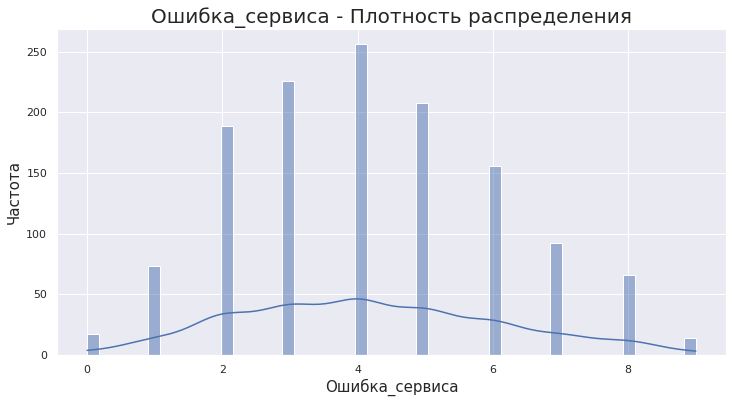

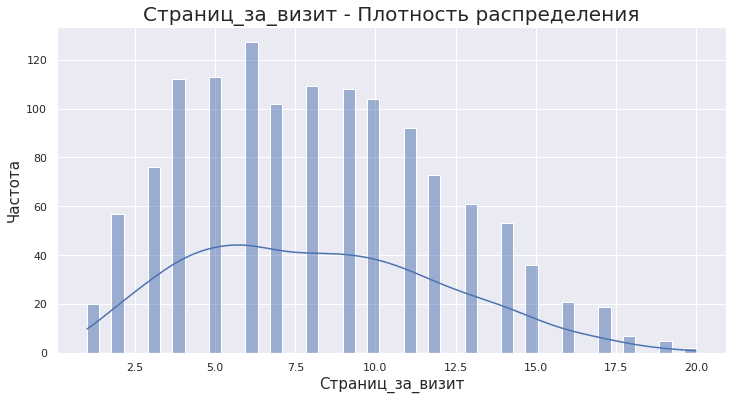

In [25]:
for num_name in num_col_names_market:
    function_for_histogram(df_market_file_filtered, num_name,bins=50)

*Нормальное распределение:* активные пользователи за 6 месяцев, пользователи текущего месяца, длительность, просмотры, ошибки сервиса

*В остальных графиках виднеются смещения*

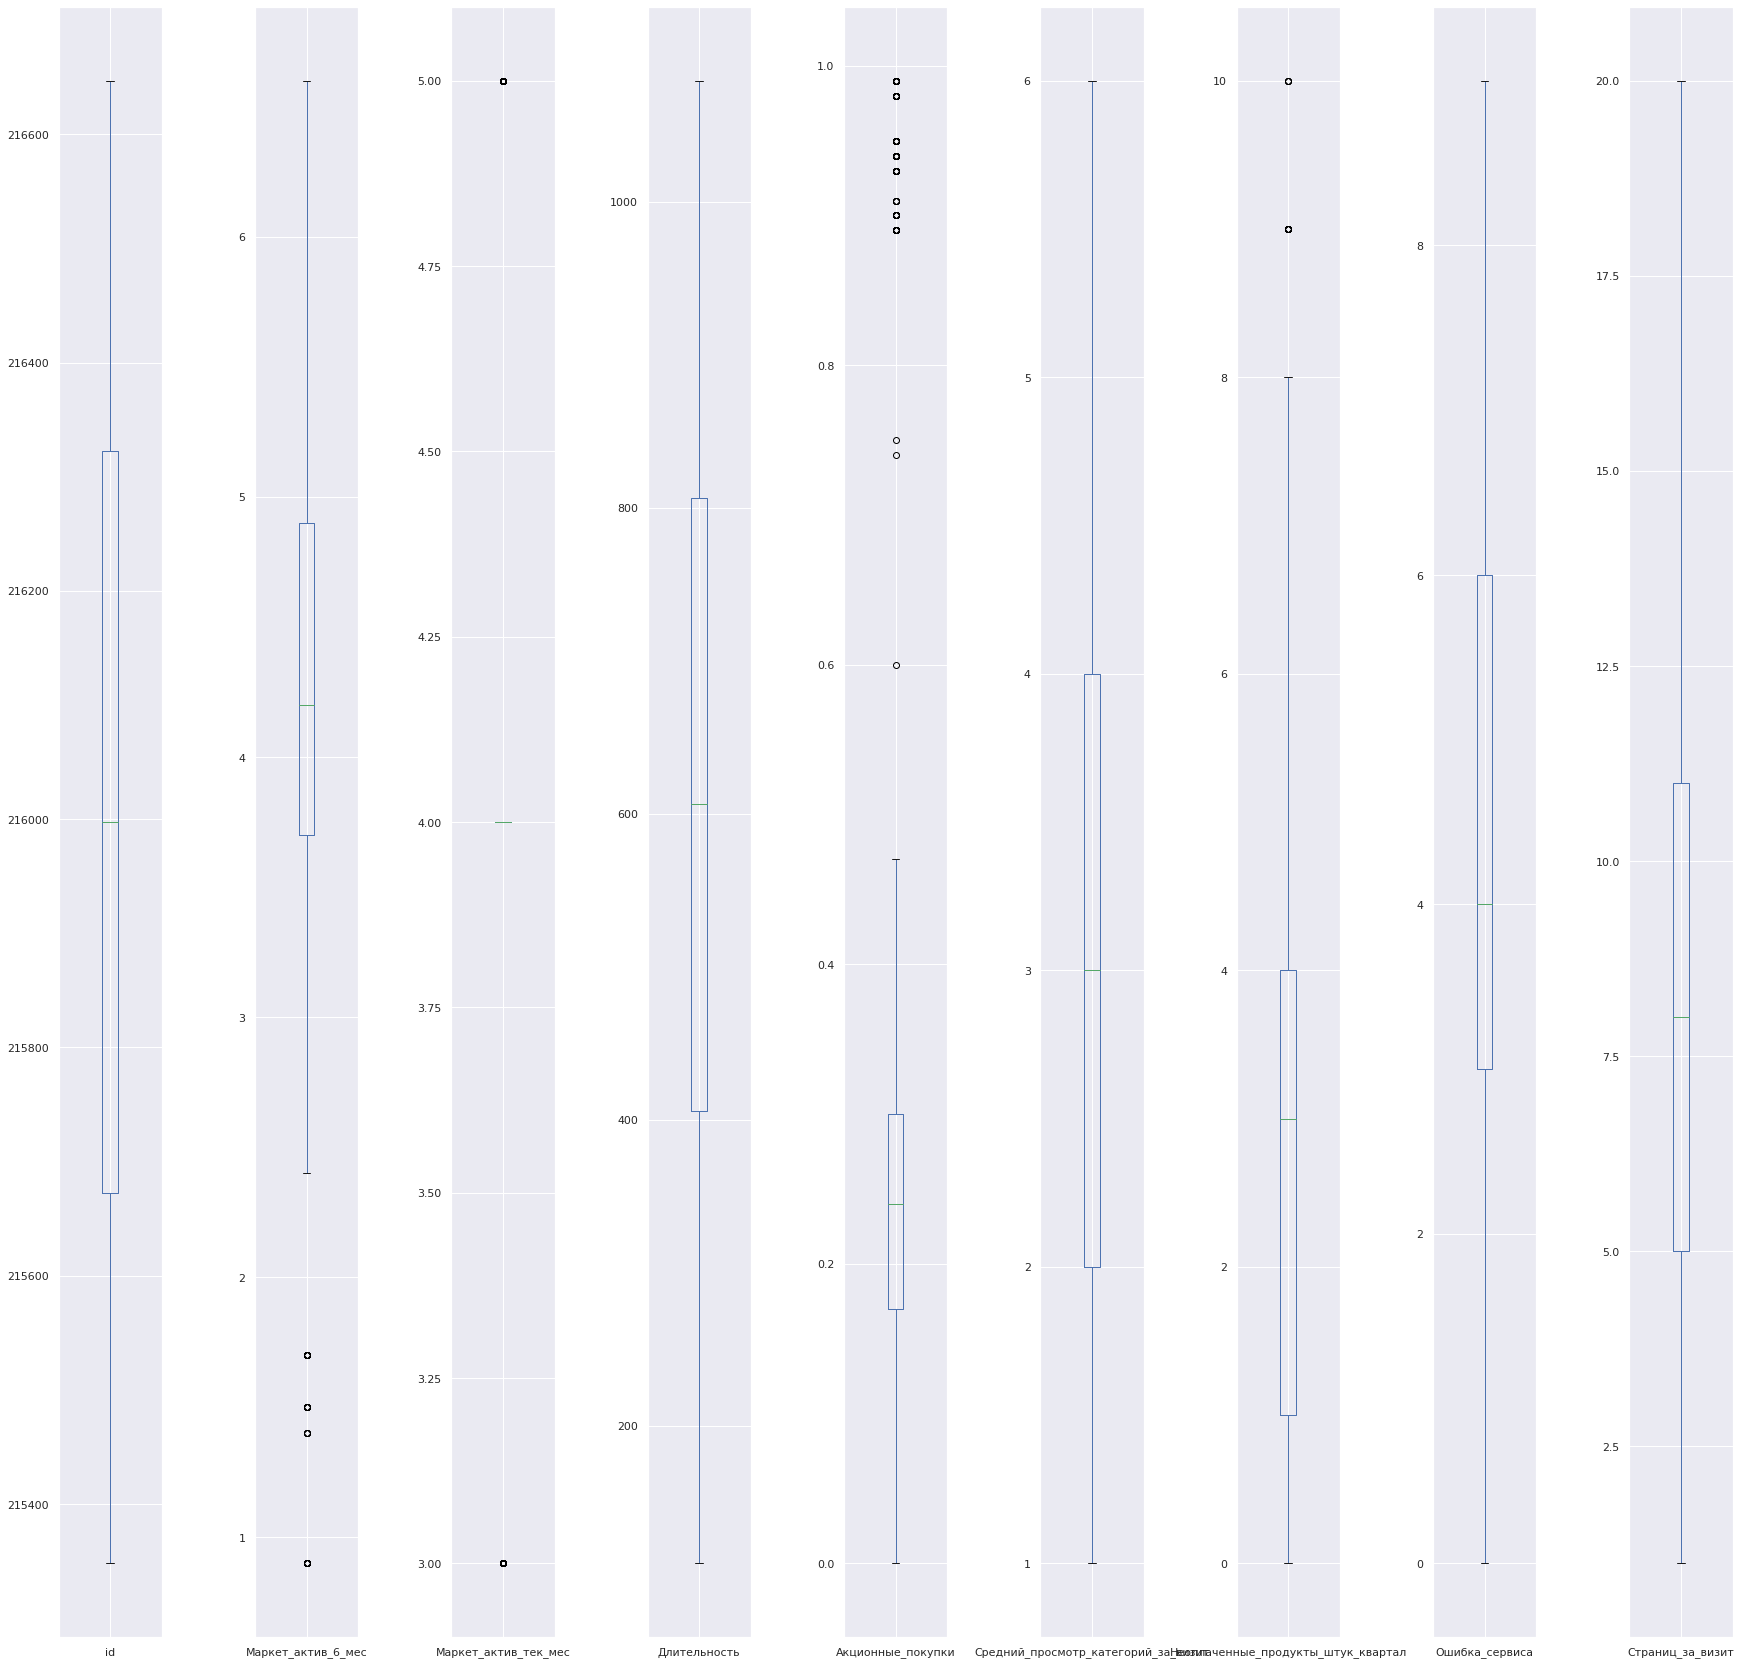

In [26]:
df_market_file.plot(kind='box', subplots=True, sharey=False, figsize=(30, 30))
plt.subplots_adjust(wspace=0.9)

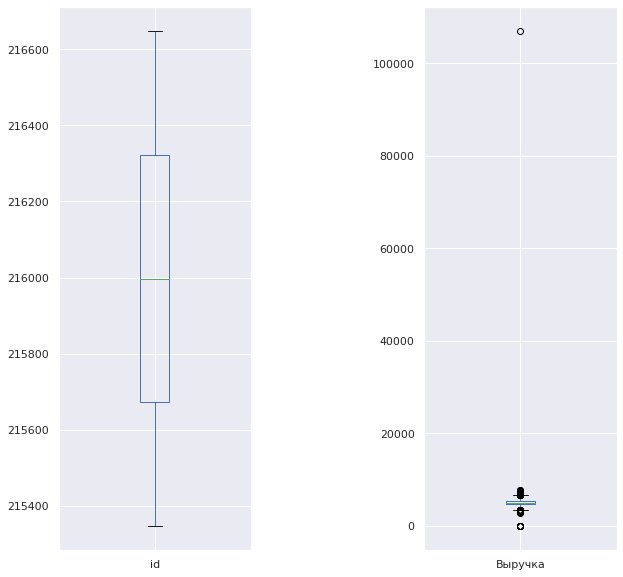

In [27]:
df_market_money.plot(kind='box', subplots=True, sharey=False, figsize=(10, 10))
plt.subplots_adjust(wspace=0.9)

In [28]:
df_market_money = df_market_money.query('Выручка < 20000').reset_index()

In [29]:
df_market_money = df_market_money.query('Выручка > 1').reset_index()

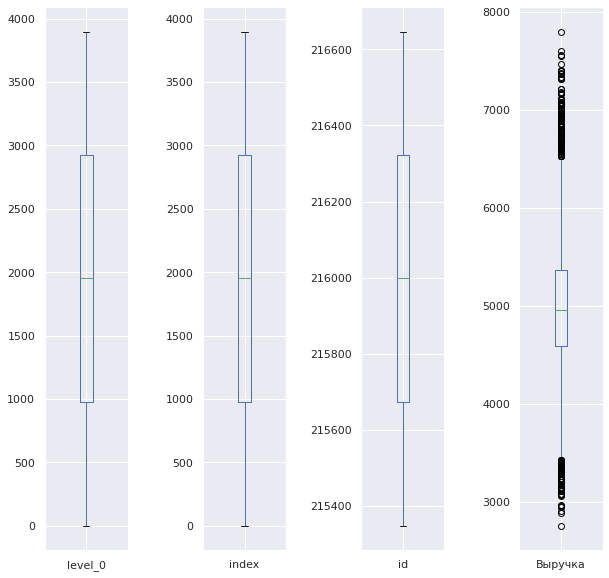

In [30]:
df_market_money.plot(kind='box', subplots=True, sharey=False, figsize=(10, 10))
plt.subplots_adjust(wspace=0.9)

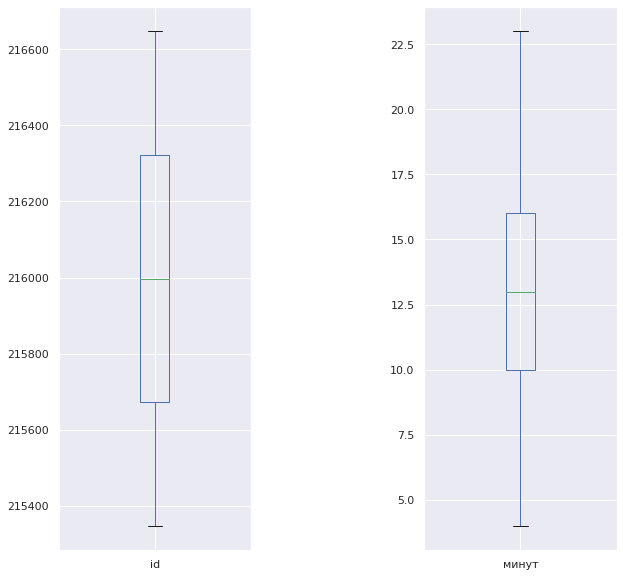

In [31]:
df_market_time.plot(kind='box', subplots=True, sharey=False, figsize=(10, 10))
plt.subplots_adjust(wspace=0.9)

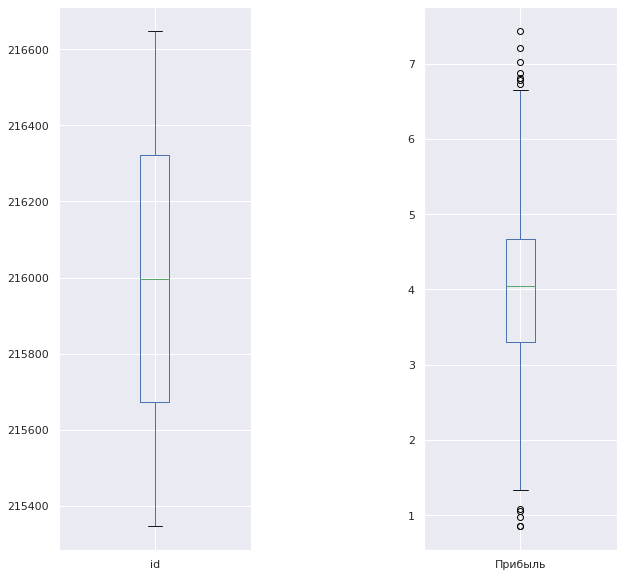

In [32]:
df_money.plot(kind='box', subplots=True, sharey=False, figsize=(10, 10))
plt.subplots_adjust(wspace=0.9) 

Все выбросы удалены, все boxplotы выглядят правильно

In [33]:
num_col_names_time, cat_col_names_time = cat_num_col(df_market_time_filtered)

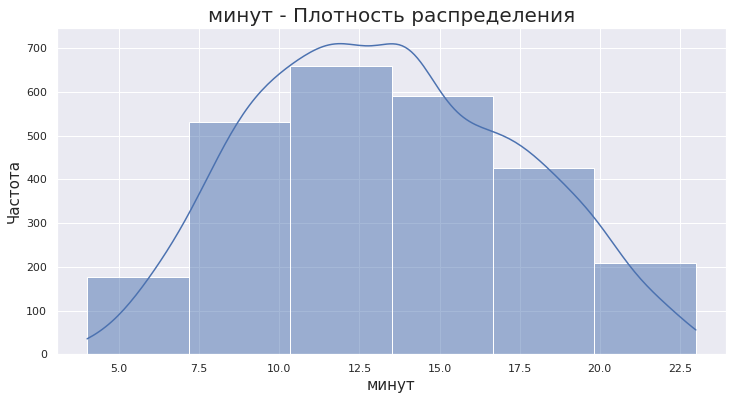

In [34]:
for num_name in num_col_names_time:
    function_for_histogram(df_market_time_filtered, num_name,bins=6)

In [35]:
num_col_names_money, cat_col_names_money = cat_num_col(df_money_filtered)

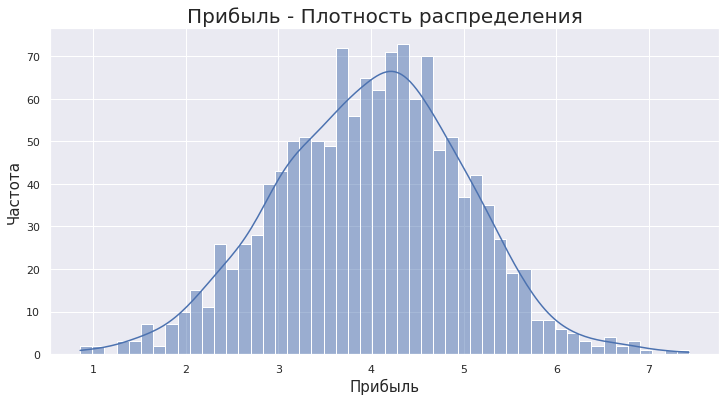

In [36]:
for num_name in num_col_names_money:
    function_for_histogram(df_money_filtered, num_name,bins=50)

Прибыль имеет нормальное распределение

In [37]:
num_col_names_market_money, cat_col_names_market_money = cat_num_col(df_market_money_filltred)

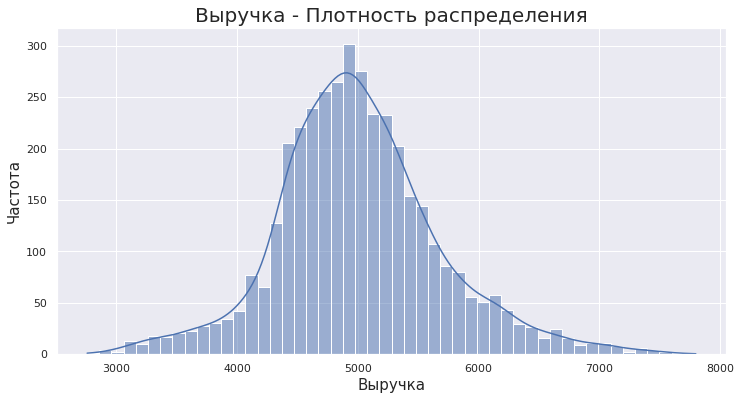

In [38]:
for num_name in num_col_names_market_money:
    function_for_histogram(df_market_money, num_name,bins=50)

После удаления выбросов выручка имеет нормальное распределение

**Шаг 4. Объединение таблиц**

In [39]:
df_market_file_filtered.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


In [40]:
df_pivot_money = df_market_money_filltred.pivot(index='id', columns='Период', values='Выручка')

In [41]:
df_pivot_money = df_pivot_money.rename(columns={
    'текущий_месяц': 'выручка_за_текущий_месяц',
    'предыдущий_месяц': 'выручка_за_предыдущий_месяц',
    'препредыдущий_месяц': 'выручка_за_препредыдущий_месяц',
    'Покупательская активность': 'Покупательская_активность'
    
})

**4**

In [42]:
merged_df = df_market_file_filtered.merge(df_pivot_money, on='id', how='left')

In [43]:
merged_df.head(20)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5
5,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6
6,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6
7,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4
8,215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5
9,215360,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5555.0,5834.9


In [44]:
df_pivot_time = df_market_time_filtered.pivot(index='id', columns='Период', values='минут')

In [45]:
df_pivot_time = df_pivot_time.rename(columns={
    'текущий_месяц': 'время_за_текущий_месяц',
    'предыдущий_месяц': 'время_за_предыдущий_месяц',
    'Покупательская активность': 'Покупательская_активность'
})

In [46]:
merged_df = merged_df.merge(df_pivot_time, on='id', how='left')

In [47]:
merged_df.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,время_за_предыдущий_месяц,время_за_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
5,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
6,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
7,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
8,215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10
9,215360,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5555.0,5834.9,9,6


In [48]:
merged_df.duplicated().sum()

0

In [49]:
merged_df.isnull().sum().sort_values()

id                                     0
выручка_за_текущий_месяц               0
выручка_за_препредыдущий_месяц         0
выручка_за_предыдущий_месяц            0
Страниц_за_визит                       0
Ошибка_сервиса                         0
Неоплаченные_продукты_штук_квартал     0
Средний_просмотр_категорий_за_визит    0
Популярная_категория                   0
Акционные_покупки                      0
Длительность                           0
Маркет_актив_тек_мес                   0
Маркет_актив_6_мес                     0
Разрешить сообщать                     0
Тип сервиса                            0
Покупательская активность              0
время_за_предыдущий_месяц              0
время_за_текущий_месяц                 0
dtype: int64

In [50]:
merged_df = merged_df.rename(columns={'Покупательская активность': 'Покупательская_активность'})

In [51]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

In [52]:
# Матрица корреляции и тепловая карта

def plot_correlation_heatmap(data):

    num_col_names = list(data.select_dtypes(include=['int64', 'float64']).columns)
    #correlation_matrix = data[num_col_names].corr()

    plt.figure(figsize=(15, 10))
    sns.heatmap(data[num_col_names].corr(method="spearman"), annot=True, linewidth=0.2)

    plt.title("Correlation Heatmap")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
  
    # Отображение
    plt.show()


interval columns not set, guessing: ['id', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц', 'время_за_предыдущий_месяц', 'время_за_текущий_месяц']


Not enough unique value for variable Покупательская_активность for analysis 1. Dropping this column


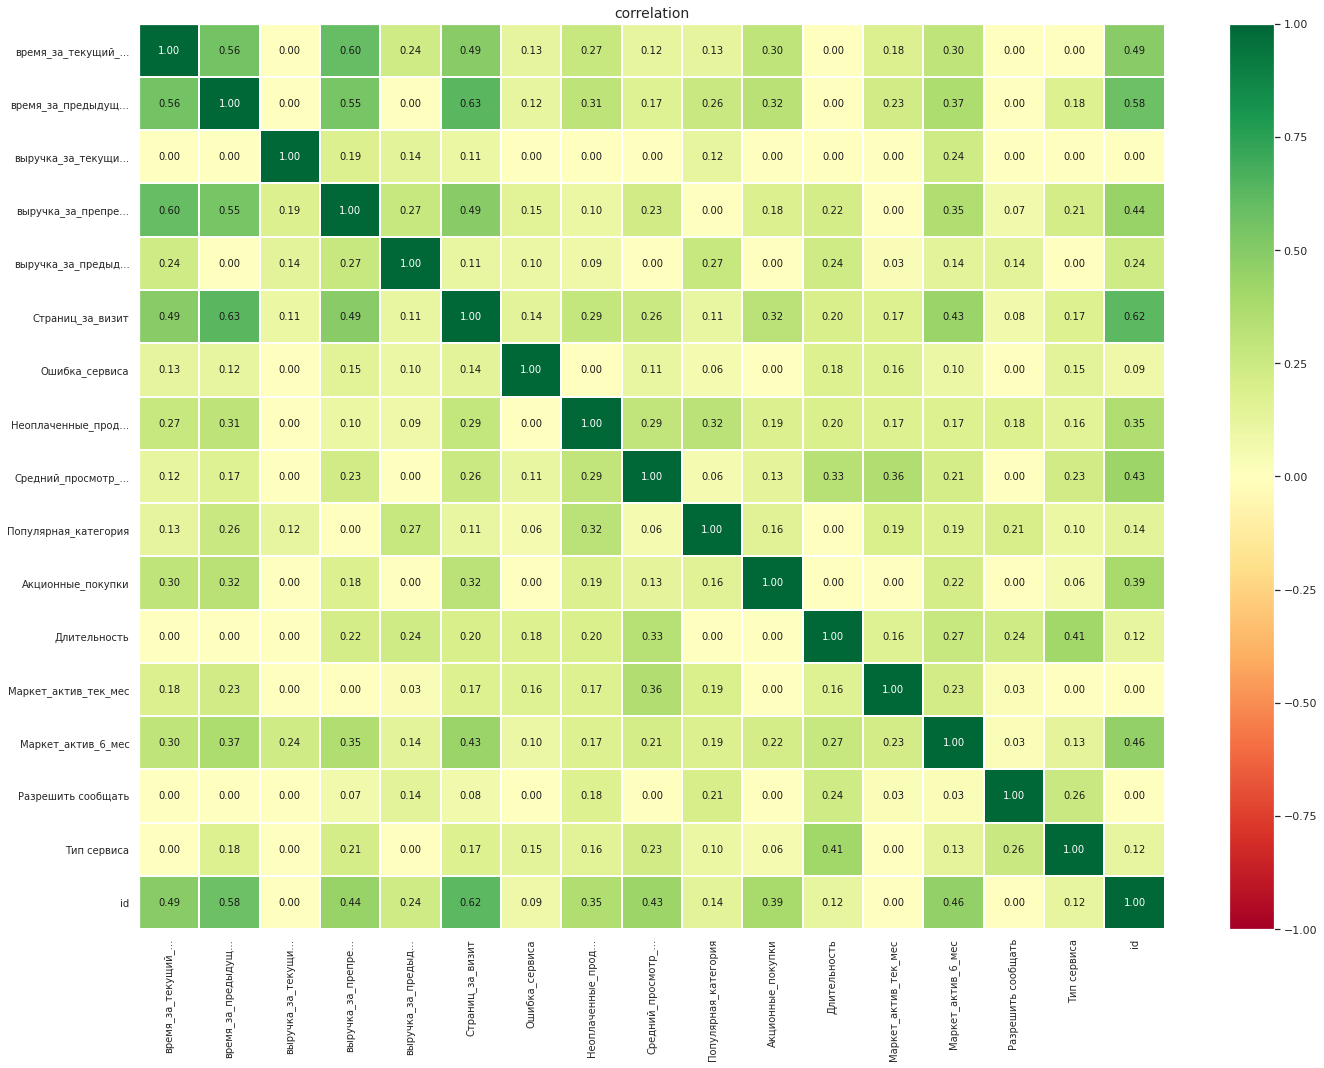

In [53]:
phik_overview = phik_matrix(merged_df[merged_df['Покупательская_активность'] == 'Снизилась'])
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        figsize=(20, 15))

interval columns not set, guessing: ['id', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц', 'время_за_предыдущий_месяц', 'время_за_текущий_месяц']


Not enough unique value for variable Покупательская_активность for analysis 1. Dropping this column


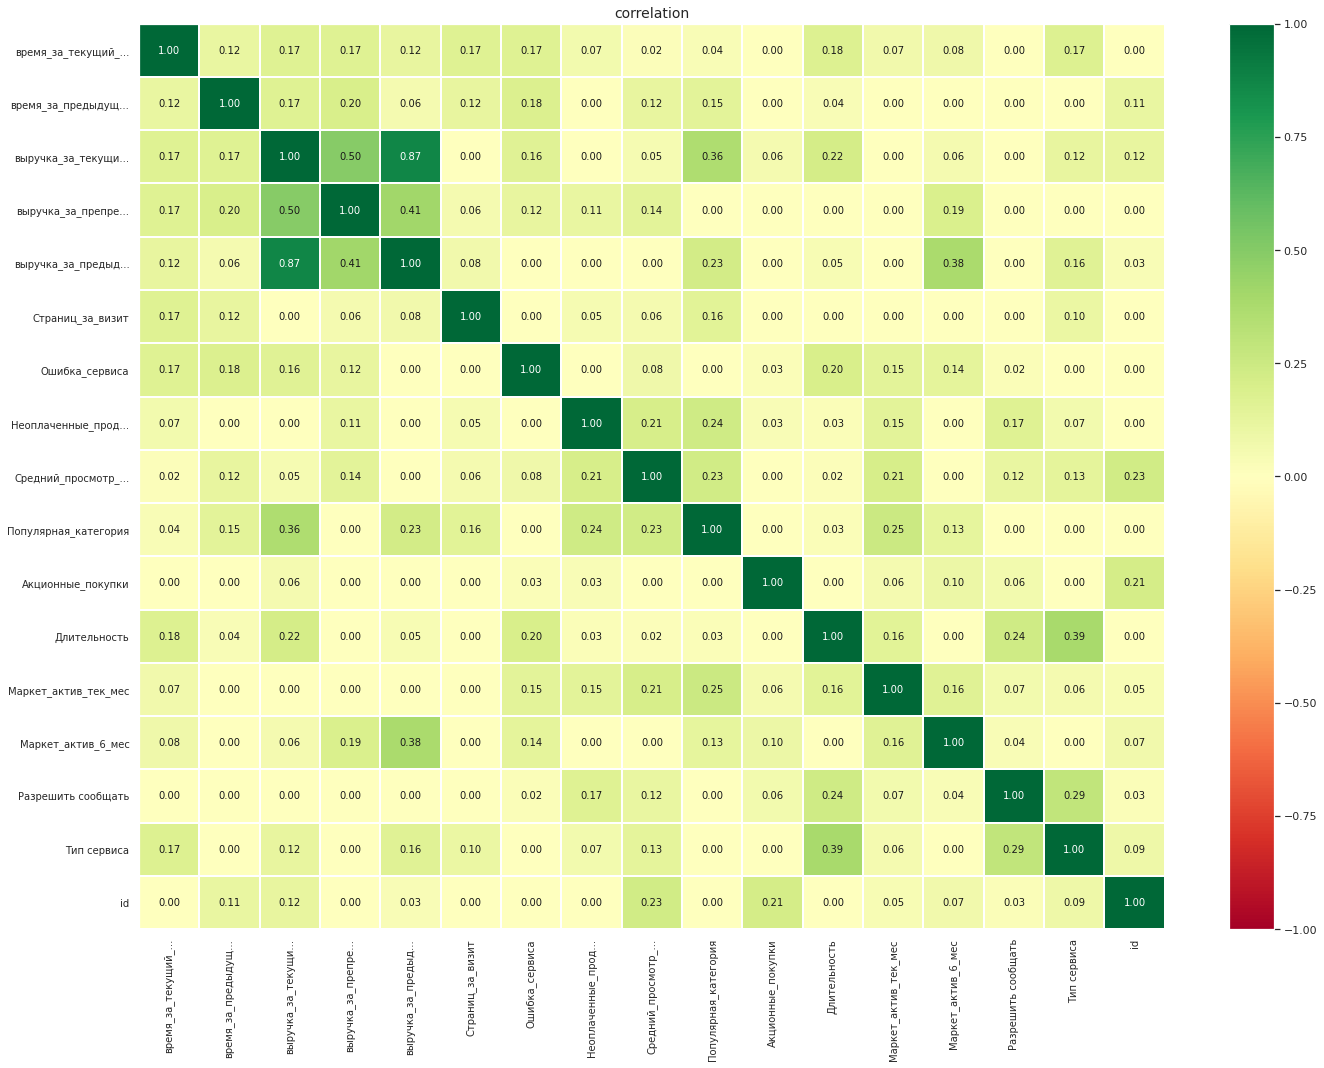

In [54]:
phik_overview = phik_matrix(merged_df[merged_df['Покупательская_активность'] == 'Прежний уровень'])
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        figsize=(20, 15))

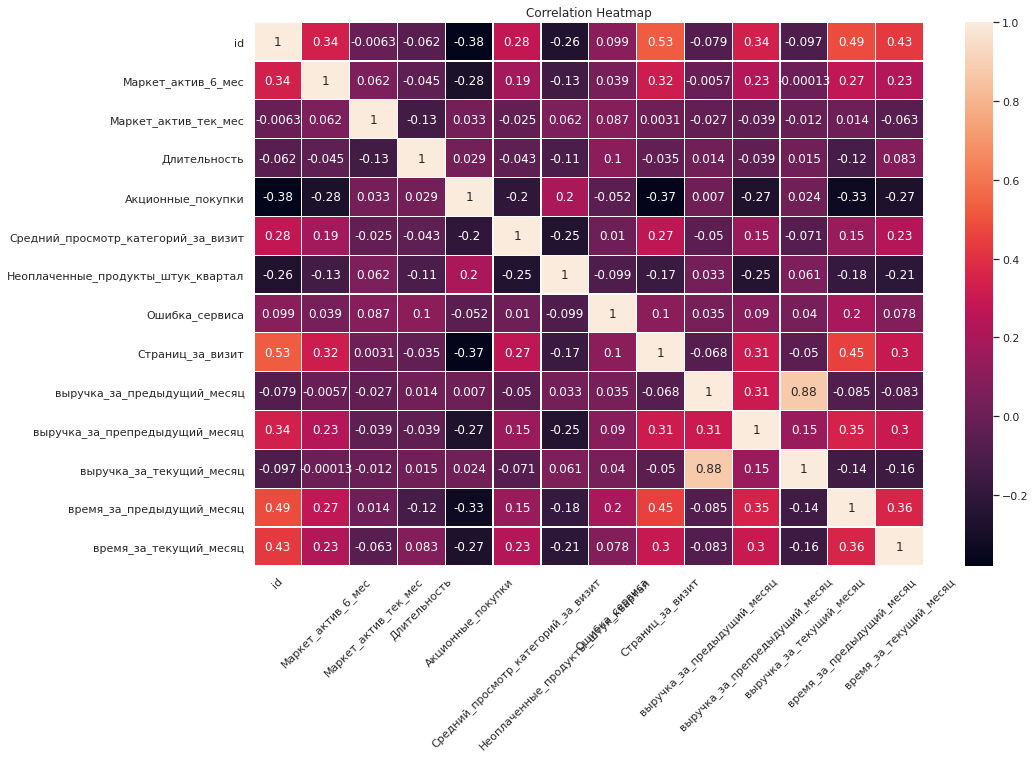

In [55]:
plot_correlation_heatmap(merged_df)

In [56]:
merged_df = merged_df.drop('id', axis=1)

In [57]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
X = merged_df.drop('Покупательская_активность', axis=1)
y = merged_df['Покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

num_cols = merged_df.select_dtypes(exclude='object').columns
ohe_cols = ['Популярная_категория']
ord_cols = ['Тип сервиса', 'Разрешить сообщать']

ohe_pipe = Pipeline(
[
    ('ohe', OneHotEncoder(drop='first', sparse=False))
])

ord_pipe = Pipeline(
    [('ord', OrdinalEncoder(
        categories =[
            ['стандарт', 'премиум'],
            ['нет', 'да']
        ]
    ))
])

data_processor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_cols),
     ('ord', ord_pipe, ord_cols),
     ('num', StandardScaler(), num_cols)
    ],
    remainder ='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_processor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': [0.1,1,10,100, 0.001],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': [0.1,1,10,100, 0.001],
        'models__kernel': ['rbf', 'sigmoid', 'linear', 'poly'],
        'models__gamma': [0.1,1,10,100, 0.001],
        'models__degree': [2,3,4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,10),
        'models__min_samples_split': range(1,10),
        'models__min_samples_leaf': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE)

random_search.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

pred = random_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred)}')

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['нет',
                          

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. 


In [58]:
model = random_search.best_estimator_.named_steps.models

In [59]:
pipe_final.fit(X_train, y_train)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['нет',
                                                                                               'да']]))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать']),
                                                 ('num', StandardScaler(),
                                                  Inde...ь',
       'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'выручка_за_предыдущий_месяц',
       'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц',
       'время_за_предыдущий_месяц', 'время_за_текущий_месяц'],
      dtype='object'))])),
                ('models', DecisionTreeClassifier(random_state=42))])

In [60]:
y_test_pred = pipe_final.predict(X_test)
print(f'Предсказание на тестируемой выборке: {y_test_pred}')

Предсказание на тестируемой выборке: [1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1
 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1
 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0
 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1
 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1
 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 1]


In [61]:
y_test_pred = pipe_final.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.8170838823012736


In [62]:
#Тестовые значения сохраняем в датафрейм + добавялем столбец с предсказанными значениями
test_df = pd.DataFrame(data=X_test)
test_df['y_pred'] = y_test_pred
test_df

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,время_за_предыдущий_месяц,время_за_текущий_месяц,y_pred
50,премиум,да,3.4,5,339,0.30,Косметика и аксесуары,2,3,3,4,5548.5,4833.0,6065.9,10,8,1
684,премиум,нет,3.8,4,570,0.14,Товары для детей,2,1,2,13,3615.0,4763.0,4739.5,16,13,0
349,премиум,да,3.1,4,681,0.27,Косметика и аксесуары,1,5,6,7,4830.5,4559.0,5805.5,10,8,0
509,стандарт,да,5.5,5,242,0.21,Кухонная посуда,5,4,4,11,4204.5,4614.0,3979.6,18,19,0
410,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,4252.0,5023.0,3713.8,12,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,стандарт,да,4.0,3,451,0.89,Домашний текстиль,2,4,3,2,5022.0,4527.0,4470.8,8,6,1
238,стандарт,да,4.8,5,574,0.27,Косметика и аксесуары,2,0,8,5,5372.0,4871.0,6363.9,8,4,1
1041,стандарт,да,4.6,5,356,0.17,Товары для детей,3,4,3,13,4973.0,4819.0,4969.1,20,9,0
597,стандарт,да,5.5,4,829,0.18,Товары для детей,3,0,5,5,3992.0,4962.0,4963.1,12,12,0


In [63]:
#Cинтезируем данные
X, y = make_classification(n_samples=500, n_features=10, n_informative=5, n_redundant=2,
                                                 n_classes=2,random_state=0)
X = pd.DataFrame(X, columns = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10'])

In [64]:
X_shap = model.fit(X, y)

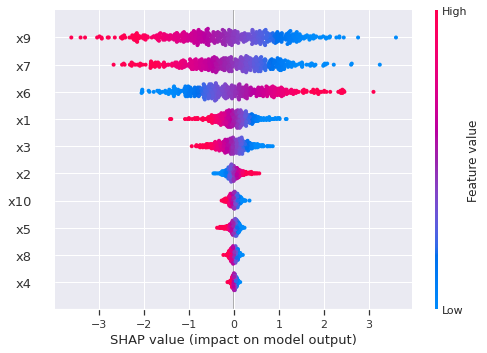

In [65]:
explainer = shap.LinearExplainer(model, X)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values)

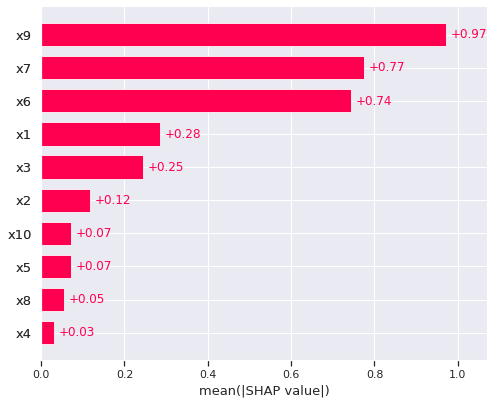

In [66]:
shap.plots.bar(shap_values)

**Шаг 8. Сегментация покупателей**

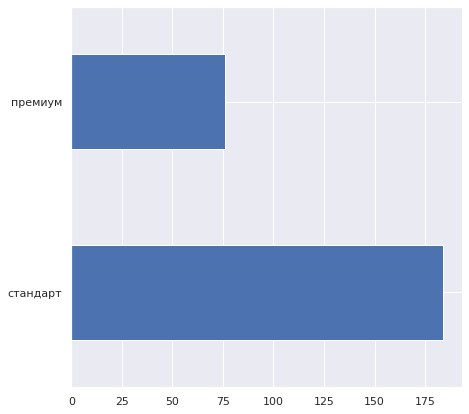

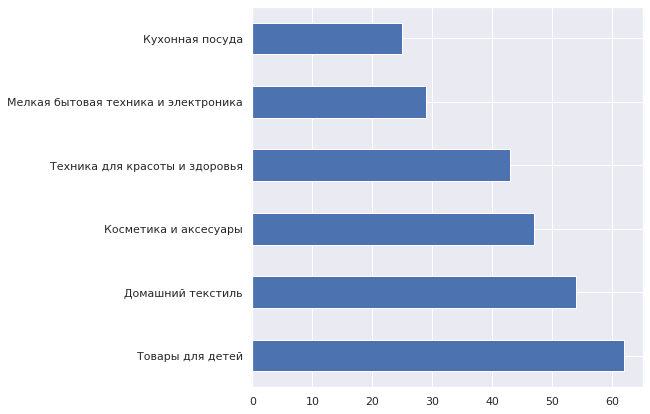

In [67]:
cat_values = ['Тип сервиса', 'Популярная_категория']
for j in cat_values:
        test_df[j].value_counts().plot(kind='barh', figsize=(7,7))
        plt.show()

Товары для детей - самая популярная категория, подписки - стандарт

Наиболее популярный сегмент - пользователи с подпиской стандарт, покупающие товары для детей. 

Предложения: добавить персонализированные скидки на товары для детей при переходе на 'премиум'. 

**Вывод**

* Была совершена предобработка данных. Удалены аномальные значения и явные/неявные дубликаты. Пропущенных значений не было обнаружено.
* Были написаны функции для построения диаграмм и боксплотов
* Корреляционный анализ проведен отдельно для каждого класса
* Были проведены исследовательский и корреляционные анализы данных. После корреляционного анализа во входные признаки были добавлены те признаки, которые более всего влияли на результат. 
* Исходя из исследовательского анализа данных наиболее популярная категорияя - детские товары. 
* Был составлен пайплайн, в качестве метрики выбрала roc_auc: наилучшей моделью оказалась SVC с метрикой на тренировочной выборке 0.89
* Метрика лучшей модели на тренировочной выборке: 0.8925160029376411, Метрика ROC-AUC на тестовой выборке: 0.8955078737687434
* Сегментация покупателей. Пользователи с подпиской стандарт, для которых любимая категория товаров - детские товары. Предложение по улучшению: предложить персонализированные скидки в категории "товары для детей" при переходе на подписку "премиум".